In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy.stats import norm

# Using the lognormal from numba_stats
# instead of scipy_stats speeds things
# up by a big factor.
# Be careful however because the call sequences
# are not exactly the sameand not all
# functions are implemented.
# from scipy.stats import lognorm
from numba_stats import lognorm

### This is fake data with 3 point
We are going to fit Data = mu*S + B with some uncertainty on B <br>

In [2]:
# This is some fake data in 3 bins
data = np.array([12, 7, 4])
sig  = np.array([ 2,  2, 2])  # signal predicted with mu=1
bg   = np.array([10,  5, 2])  # bg predicted
err  = 0.2*bg                 # bg uncertainty

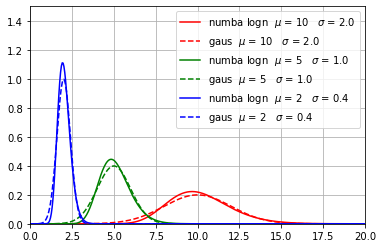

In [3]:
# check that lognormal makese sense, compare with gaussian
color = ('red', 'green', 'blue')
ax=plt.subplot(111)
for b,e,c in zip(bg, err, color):
    x = np.linspace(0.01, 20., 400)
    ax.plot(x, lognorm.pdf(x, np.log(1+e/b), 0, b), color=c, 
            label='numba logn  $\mu$ = '+str(b) + '   $\sigma$ = ' + str(e))
    ax.plot(x, norm.pdf(x,    scale=e, loc=b), color=c, linestyle='dashed', 
            label='gaus  $\mu$ = '+str(b) + '   $\sigma$ = ' + str(e))

ax.grid()
ax.legend()
ax.set_xlim([0, 20.])
_ = ax.set_ylim(0,1.5)

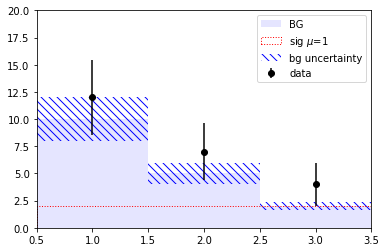

In [4]:
# plot it
x = np.array([1.,2.,3.])
b = np.array([0.5, 1.5, 2.5, 3.5, 4.5])
ax = plt.subplot(111)
ax.hist(x, b, weights=bg,  alpha=0.1, color='blue', label='BG', histtype='stepfilled')

n1,b1,p1 = ax.hist(x, b, weights=bg+err, histtype='stepfilled',
                   facecolor='none', edgecolor='none', linestyle='--')
n2,b2,p2 = ax.hist(x, b, weights=bg-err, histtype='stepfilled', 
                   facecolor='none', edgecolor='none', linestyle='--')
ax.bar(x=b1[:-1], height=n2-n1, bottom=n1, width=np.diff(b1),
       align='edge', linewidth=0, edgecolor='blue', color='none', zorder=-1, 
       label='bg uncertainty', hatch='\\\\\\')

ax.hist(x, b, weights=sig, color='red', label='sig $\mu$=1', histtype='step',
        linestyle='dotted')
ax.errorbar(x, data, yerr=np.sqrt(data), fmt='o', color='black', label='data')
# ax.bar(x, sig, align='center',width=1, color='None', edgecolor='red', label='sig ($\mu$=1)')

ax.set_xlim((0.5, 3.5))
ax.legend()
_ = ax.set_ylim((0,20))

In [5]:
class myFit:
    """
    Simplest example of wrapper around a minuit function
    NLL fit to bins of data = mu*signal + background
    including sigma of background (absolute)
    
    Sample usage:
    Example of 3 bins, np.arrays are to be passed.
    The fit parameters ordered for pinit are
       mu, 1st bin bg, 2bd bin bg, 3rd bin bg
    
    f = myFit(data, signal, background, sigma)
    m = Minuit(f.myNLL, pinit, name=("mu", "b1", "b2", 'b3'))
    m.errordef = Minuit.LIKELIHOOD
    m.simplex()
    m.migrad()
    m.minos()
    
    After defining "f" can change data members as
    f.d  = newData
    f.b  = newBG
    f.s  = newSignal
    f.eb = newBGsigma
    """
    def __init__(self, d, s, b, eb):
        self.d     = d
        self.b     = b
        self.eb    = eb
        self.s     = s
        self.blah  = np.log(1+eb/b)

    # This should really protect against logs of negative numbers
    def myNLL(self, p):
        mu = p[0]
        fitbg = p[1:]
        temp1 = (-self.d * np.log(mu*self.s + fitbg) + mu*self.s + fitbg).sum()
        #temp2 = 0
        #for bb,ee,fit in zip(self.b, self.eb, fitbg):
        #    pdf = lognorm.pdf(fit, np.log(1+ee/bb), scale=bb)
        #   temp2 = temp2 - np.log(pdf)
        #return temp1+temp2
        return temp1 - (np.log(lognorm.pdf(fitbg, self.blah, 0, self.b))).sum()

In [6]:
# Initialize a myFit object that contains the
# data, the signal model (mu=1), the pre-fit bg
# prediction, its uncertainty, as well as the
# negative log-likelihood function
thisFit = myFit(data, sig, bg, err)

# initialize a Minuit object with pinit as the initial guess
pinit     = np.array([1, bg[0], bg[1], bg[2]])
mData = Minuit(thisFit.myNLL, pinit, name=("mu", "b1", "b2", 'b3'))
mData.errordef = Minuit.LIKELIHOOD
mData.limits['mu'] = (-0.5, None)   # force mu>-0.5
#mData.simplex()
#mData.migrad()
#mData.minos()

In [7]:
# The standard minimizer
mData.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -23.78                     │              Nfcn = 59               │
│ EDM = 1.84e-05 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │    1.1    │    0.8    │            │            │  -0.5   │         │       │
│ 1 │ b1   │    9.7    │    1.6    │            │            │         │         │       │
│ 2 │ b2   │    4.8    │    0.9    │            │            │         │         │       │
│ 3 │ b3   │   1.93    │   0.35    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────┐
│    │      mu      b1      b2      b3 │
├────┼─────────────────────────────────┤
│ mu │   0.579  -0.246  -0.117 -0.0337 │
│ b1 │  -0.246    2.59  0.0495  0.0143 │
│ b2 │  -0.117  0.0495   0.725 0.00679 │
│ b3 │ -0.0337  0.0143 0.00679   0.122 │
└────┴─────────────────────────────────┘

In [8]:
# Calculate Aymmetric Errors
mData.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -23.78                     │              Nfcn = 519              │
│ EDM = 1.84e-05 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │    1.1    │    0.8    │    -0.7    │    0.8     │  -0.5   │         │       │
│ 1 │ b1   │    9.7    │    1.6    │    -1.5    │    1.7     │         │         │       │
│ 2 │ b2   │    4.8    │    0.9    │    -0.8    │    0.9     │         │         │       │
│ 3 │ b3   │   1.93    │   0.35    │   -0.32    │    0.38    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │          mu           │          b1           │          b2           │          b3           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.7    │    0.8    │   -1.5    │    1.7    │   -0.8    │    0.9    │   -0.32   │   0.38    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌────┬─────────────────────────────────┐
│    │      mu      b1      b2      b3 │
├────┼─────────────────────────────────┤
│ mu │   0.579  -0.246  -0.117 -0.0337 │
│ b1 │  -0.246    2.59  0.0495  0.0143 │
│ b2 │  -0.117  0.0495   0.725 0.00679 │
│ b3 │ -0.0337  0.0143 0.00679   0.122 │
└────┴─────────────────────────────────┘

In [9]:
# You can get the results of the fit from the 
# Minuit object.  For example, the for the 0th parameter, ie, mu
print("mu =", round(mData.values[0],3), "+/-", round(mData.errors[0],3))
print("Minos errors:")
print(round(mData.merrors["mu"].lower,3), " +", 
      round(mData.merrors["mu"].upper,3), sep="")

mu = 1.066 +/- 0.754
Minos errors:
-0.696 +0.826


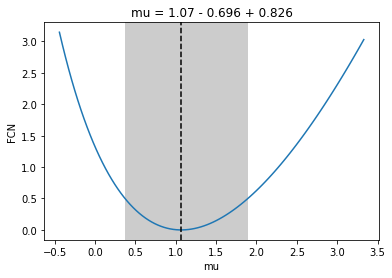

In [10]:
# Show a profile log likelihood scan (this is just for fun)
mumin = mData.values[0] - 2*mData.errors[0]
mumax = mData.values[0] + 3*mData.errors[0]
mu, loglik= mData.draw_mnprofile("mu",size=100, bound=[mumin,mumax], subtract_min=True)

Text(0, 0.5, '$\\Delta$log-lik')

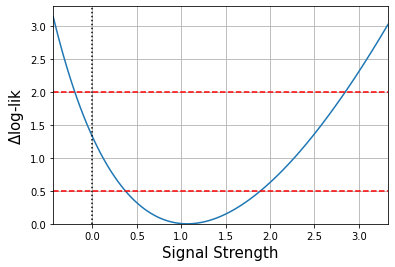

In [11]:
# It does not look so pretty, but we can redraw it
ax = plt.subplot(111)
ax.plot(mu,loglik)
ax.set_xlim(mu[0], mu[-1])
ax.set_ylim(bottom=0)
ax.grid()
ax.plot([0,0],[0,ax.get_ylim()[1]], color='black',linestyle='dotted')
ax.plot([mu[0], mu[-1]], [0.5, 0.5], color='red', linestyle='dashed')
ax.plot([mu[0], mu[-1]], [2.0, 2.0], color='red', linestyle='dashed')
ax.set_xlabel("Signal Strength", size=15)
ax.set_ylabel("$\Delta$log-lik", size=15)

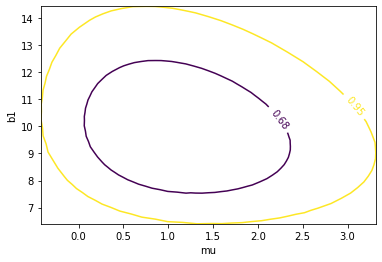

In [12]:
# an example of a countour plot
mData.draw_mncontour("mu","b1", cl=[0.68,0.95])

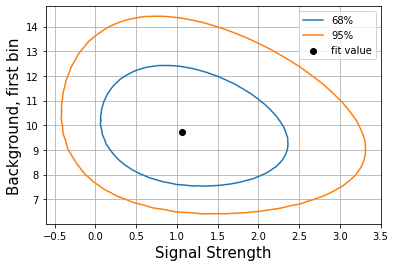

In [13]:
# make it prettier
p68    = mData.mncontour("mu","b1",cl=0.68)
p95    = mData.mncontour("mu","b1",cl=0.95)
# close the boundaries
x68 = p68[:,0]
y68 = p68[:,1]
x68 = np.append(x68,x68[0])
y68 = np.append(y68,y68[0])
x95 = p95[:,0]
y95 = p95[:,1]
x95 = np.append(x95,x95[0])
y95 = np.append(y95,y95[0])

ax = plt.subplot(111)
ax.plot(x68,y68, label="68%")
ax.plot(x95,y95, label="95%")
ax.grid()
ax.scatter(mData.values[0], mData.values[1], color='black', label="fit value")
ax.set_xlabel("Signal Strength", size=15)
ax.set_ylabel("Background, first bin", size=15)
ax.legend()